### Salvar y guardar modelos en Pytorch

Cuando se trata de guardar y cargar modelos, hay tres funciones básicas con las que debe estar familiarizado:

`torch.save`: Guarda un objeto serializado en el disco. Esta función utiliza la utilidad pickle de Python para la serialización. Con esta función se pueden guardar modelos, tensores y diccionarios de todo tipo de objetos.

`torch.load`: Permite cargar y restaurar tensores, modelos, optimizadores y otros objetos de PyTorch desde archivos guardados en disco.

`torch.nn.Module.load_state_dict`: Carga el diccionario de parámetros de un modelo utilizando un state_dict deserializado.

In [10]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets 
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import shutil#shell utils
import numpy as np
import os

In [2]:
# Download training data from open datasets.
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

# Download test data from open datasets.
test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)


print(f"Amount of training data: {len(training_data.targets)}, and test data: {len(test_data.targets)}")

batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

Amount of training data: 60000, and test data: 10000


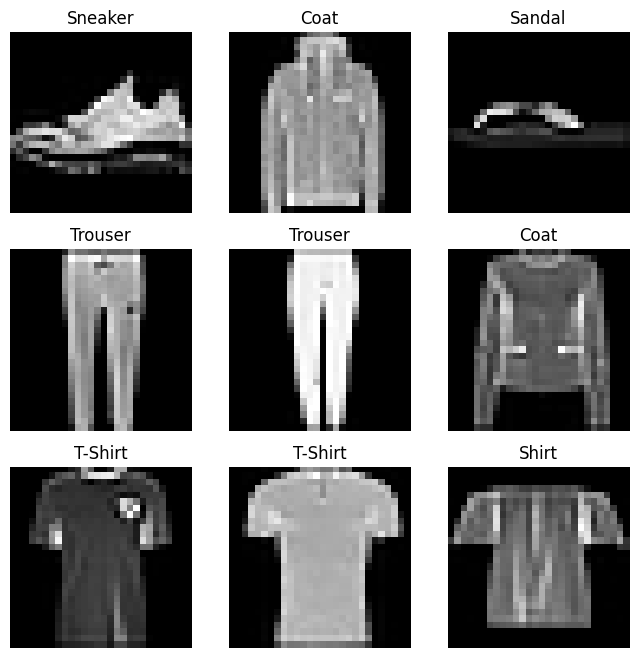

In [3]:
labels_map = {
    0: "T-Shirt",
    1: "Trouser",
    2: "Pullover",
    3: "Dress",
    4: "Coat",
    5: "Sandal",
    6: "Shirt",
    7: "Sneaker",
    8: "Bag",
    9: "Ankle Boot",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(training_data), size=(1,)).item()
    img, label = training_data[sample_idx]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device} device")

#Defining the model
class NeuralNetwork(nn.Module):
  def __init__(self):
    super(NeuralNetwork, self).__init__()
    self.flatten = nn.Flatten()
    self.linear_relu_stack = nn.Sequential(nn.Linear(in_features=28*28, out_features=512),
                                           nn.ReLU(),
                                           nn.Linear(512, 512),
                                           nn.ReLU(),
                                           nn.Linear(512, 10))
    
  def forward(self, x):
    x = self.flatten(x)
    logits = self.linear_relu_stack(x)
    return logits

Running on: cpu device


In [26]:
model = NeuralNetwork().to(device)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)

#training 
def training(model, dataloader, loss_fn, optimizer):
  size = len(dataloader.dataset)#actual dataset size
  model.train()
  for batch_id, (X, y) in enumerate(dataloader):
    X, y = X.to(device), y.to(device)
    
    #getting the class predictions
    pred = model(X)
    #computing the loss
    loss = loss_fn(pred, y)

    # weights update
    optimizer.zero_grad() # to "clean" the gradients memory
    loss.backward() # chain rule 
    optimizer.step() # weights updating

    if batch_id % 100 == 0:
      loss, current_sample = loss.item(), batch_id*len(X)
      print(f"loss: {loss:>3f} [{current_sample:>5d}/{size:>5d}]")

#test loop
def test(model, dataloader, loss_fn):
  size = len(dataloader.dataset)#amount of available data
  num_batches = len(dataloader) 
  model.eval()#avoid the model learning
  test_loss, correct = 0, 0
  # no gradients calculation
  with torch.no_grad():
    for X, y in dataloader:
      X, y = X.to(device), y.to(device)
      #get the predictions
      pred = model(X)
      #computing the loss 
      test_loss += loss_fn(pred, y).item() #Returns the value of this tensor as a standard Python number
      correct += (pred.argmax(1)==y).type(torch.float).sum().item()
  
  test_loss /= num_batches
  correct /= size
  acc = 100*correct
  print(f"Test error: \n Acc: {(acc):>0.1f}%, avg loss: {test_loss:>8f}\n")


NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
    (3): ReLU()
    (4): Linear(in_features=512, out_features=10, bias=True)
  )
)


In [5]:
epochs = 5
for i in range(epochs):
  print(f"Epoch {i+1}\n ---------------------------")
  training(model, train_dataloader, loss_fn, optimizer)
  test(model, test_dataloader, loss_fn)
print("done")

Epoch 1
 ---------------------------
loss: 2.296450 [    0/60000]
loss: 2.286823 [ 6400/60000]
loss: 2.271200 [12800/60000]
loss: 2.269723 [19200/60000]
loss: 2.264821 [25600/60000]
loss: 2.230694 [32000/60000]
loss: 2.243046 [38400/60000]
loss: 2.213334 [44800/60000]
loss: 2.213924 [51200/60000]
loss: 2.185592 [57600/60000]
Test error: 
 Acc: 35.8%, avg loss: 2.179784

Epoch 2
 ---------------------------
loss: 2.182722 [    0/60000]
loss: 2.175990 [ 6400/60000]
loss: 2.130765 [12800/60000]
loss: 2.143930 [19200/60000]
loss: 2.115155 [25600/60000]
loss: 2.049794 [32000/60000]
loss: 2.082120 [38400/60000]
loss: 2.016186 [44800/60000]
loss: 2.020479 [51200/60000]
loss: 1.950559 [57600/60000]
Test error: 
 Acc: 56.1%, avg loss: 1.952666

Epoch 3
 ---------------------------
loss: 1.972815 [    0/60000]
loss: 1.949125 [ 6400/60000]
loss: 1.853027 [12800/60000]
loss: 1.881695 [19200/60000]
loss: 1.792165 [25600/60000]
loss: 1.728647 [32000/60000]
loss: 1.753228 [38400/60000]
loss: 1.660386

In [10]:
model.state_dict()

OrderedDict([('linear_relu_stack.0.weight',
              tensor([[-0.0092,  0.0186, -0.0288,  ..., -0.0071, -0.0288, -0.0078],
                      [ 0.0058,  0.0168,  0.0301,  ..., -0.0227, -0.0224,  0.0219],
                      [-0.0300, -0.0265, -0.0214,  ...,  0.0284, -0.0175, -0.0153],
                      ...,
                      [-0.0160, -0.0056,  0.0088,  ..., -0.0286, -0.0199, -0.0343],
                      [ 0.0090, -0.0058,  0.0275,  ...,  0.0289,  0.0015,  0.0122],
                      [ 0.0102,  0.0336,  0.0330,  ..., -0.0191,  0.0301,  0.0144]])),
             ('linear_relu_stack.0.bias',
              tensor([-0.0250,  0.0255, -0.0083, -0.0106,  0.0243, -0.0036,  0.0027, -0.0044,
                       0.0283, -0.0354,  0.0001,  0.0186,  0.0297, -0.0167,  0.0308, -0.0155,
                      -0.0259,  0.0176, -0.0264, -0.0093, -0.0293,  0.0154,  0.0358,  0.0322,
                      -0.0343,  0.0049, -0.0096, -0.0055,  0.0431, -0.0185, -0.0129,  0.0270,
    

¿Qué es un estado_dict?
En PyTorch, los parámetros aprendibles (es decir, pesos y sesgos) de un modelo torch.nn.Module están contenidos en los parámetros del modelo (a los que se accede con model.parameters()). Un state_dict es simplemente un objeto diccionario de Python que asigna cada capa a su tensor de parámetros. Tenga en cuenta que sólo las capas con parámetros aprendibles (capas convolucionales, capas lineales, etc.) tienen entradas en el state_dict del modelo. Los objetos optimizadores (torch.optim) también tienen un state_dict, que contiene información sobre el estado del optimizador, así como los hiperparámetros utilizados.

Debido a que los objetos state_dict son diccionarios de Python, pueden ser fácilmente guardados, actualizados, alterados y restaurados, añadiendo una gran modularidad a los modelos y optimizadores de PyTorch.



In [9]:
print("Model's state_dict:")
for param_tensor in model.state_dict():
    print(param_tensor, "\t", model.state_dict()[param_tensor].size())

# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Model's state_dict:
linear_relu_stack.0.weight 	 torch.Size([512, 784])
linear_relu_stack.0.bias 	 torch.Size([512])
linear_relu_stack.2.weight 	 torch.Size([512, 512])
linear_relu_stack.2.bias 	 torch.Size([512])
linear_relu_stack.4.weight 	 torch.Size([10, 512])
linear_relu_stack.4.bias 	 torch.Size([10])
Optimizer's state_dict:
state 	 {0: {'momentum_buffer': None}, 1: {'momentum_buffer': None}, 2: {'momentum_buffer': None}, 3: {'momentum_buffer': None}, 4: {'momentum_buffer': None}, 5: {'momentum_buffer': None}}
param_groups 	 [{'lr': 0.001, 'momentum': 0, 'dampening': 0, 'weight_decay': 0, 'nesterov': False, 'maximize': False, 'foreach': None, 'differentiable': False, 'params': [0, 1, 2, 3, 4, 5]}]


`torch.save(model, PATH)`

In [15]:
os.makedirs("data/models/", exist_ok=True)
model_name = "my_first_model.pt"
model_pt = "data/models/" + model_name

torch.save(model.state_dict(), model_pt)
print("Saved PyTorch Model State to model.pt")

Saved PyTorch Model State to model.pt


`model = torch.load(PATH)`

`model.eval()`

In [ ]:
model = NeuralNetwork()
model.load_state_dict(torch.load(model_pt))
print("model loaded correctly!")

In [19]:
classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

x, y = test_data[1][0], test_data[1][1]
with torch.no_grad():
  pred = model(x)
  predicted, actual = classes[pred[0].argmax(0)], classes[y]
  print(f"Predicted: '{predicted}' Actual: '{actual}'")

Predicted: 'Pullover' Actual: 'Pullover'


In [20]:
torch.save({
    'epoch': epochs,
    'modelo_state_dict': model.state_dict(),
    'optimizador_state_dict': optimizer.state_dict(),
    'loss': loss_fn
}, "modelo.pt")

In [22]:
checkpoint = torch.load("modelo.pt")
modelo_cargado = NeuralNetwork()
modelo_cargado.load_state_dict(checkpoint['modelo_state_dict'])
modelo_cargado.eval() 
optimizer.load_state_dict(checkpoint['optimizador_state_dict'])
epoch_cargada = checkpoint['epoch']
loss_cargada = checkpoint['loss']


CrossEntropyLoss()


Continuando el entrenamiento 

In [29]:
checkpoint = torch.load("modelo.pt")
model = NeuralNetwork().to(device)
model.load_state_dict(checkpoint['modelo_state_dict'])
optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer.load_state_dict(checkpoint['optimizador_state_dict'])
start_epoch = checkpoint['epoch']
loss = checkpoint['loss']


for i in range(start_epoch,start_epoch+5):
  print(f"Epoch {1+i}\n ---------------------------")
  training(model, train_dataloader, loss_fn, optimizer)
  test(model, test_dataloader, loss_fn)
  
print("done")

Epoch 6
 ---------------------------
loss: 1.176014 [    0/60000]
loss: 1.181037 [ 6400/60000]
loss: 1.008877 [12800/60000]
loss: 1.132295 [19200/60000]
loss: 1.014747 [25600/60000]
loss: 1.041423 [32000/60000]
loss: 1.076947 [38400/60000]
loss: 1.023299 [44800/60000]
loss: 1.058626 [51200/60000]
loss: 0.986244 [57600/60000]
Test error: 
 Acc: 65.9%, avg loss: 0.999278

Epoch 7
 ---------------------------
loss: 1.046636 [    0/60000]
loss: 1.073650 [ 6400/60000]
loss: 0.884803 [12800/60000]
loss: 1.032922 [19200/60000]
loss: 0.915700 [25600/60000]
loss: 0.940358 [32000/60000]
loss: 0.991169 [38400/60000]
loss: 0.941460 [44800/60000]
loss: 0.973715 [51200/60000]
loss: 0.913399 [57600/60000]
Test error: 
 Acc: 67.3%, avg loss: 0.920115

Epoch 8
 ---------------------------
loss: 0.951513 [    0/60000]
loss: 0.999244 [ 6400/60000]
loss: 0.795884 [12800/60000]
loss: 0.963479 [19200/60000]
loss: 0.849574 [25600/60000]
loss: 0.866801 [32000/60000]
loss: 0.931565 [38400/60000]
loss: 0.886477